In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split

sys.path.append("..")

from shift_detector import *
from shift_reductor import *
from shift_experiments import *
from shift_tester import *
from shift_utils import *
from shift_models import *
from shift_constants import *
from shift_plot_utils import *

sys.path.append("../..")

import sqlalchemy
from sqlalchemy import select, func, extract, desc
from sqlalchemy.sql.expression import and_

from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection

import config
import cyclops
from cyclops.processors.column_names import (
    ENCOUNTER_ID,
    HOSPITAL_ID,
    ADMIT_TIMESTAMP,
    DISCHARGE_TIMESTAMP,
    DISCHARGE_DISPOSITION,
    READMISSION,
    AGE,
    SEX,
    TOTAL_COST,
    CITY,
    PROVINCE,
    COUNTRY,
    LANGUAGE,
    LENGTH_OF_STAY_IN_ER,
    VITAL_MEASUREMENT_NAME,
    VITAL_MEASUREMENT_VALUE,
    VITAL_MEASUREMENT_TIMESTAMP,
    LAB_TEST_NAME,
    LAB_TEST_TIMESTAMP,
    LAB_TEST_RESULT_VALUE,
    LAB_TEST_RESULT_UNIT,
    REFERENCE_RANGE,
)
from cyclops.processors.constants import EMPTY_STRING
from cyclops.processors.admin import AdminProcessor
from cyclops.processors.vitals import VitalsProcessor
from cyclops.processors.labs import LabsProcessor
from cyclops.processors.outcomes import OutcomesProcessor
from cyclops.processors.feature_handler import FeatureHandler
from cyclops.orm import Database

%reload_ext autoreload
%reload_ext nb_black

2022-03-17 12:09:42.983164: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0.4/lib/R/lib::/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-03-17 12:09:42.983223: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-17 12:09:45.580422: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-17 12:09:45.580491: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cpu1.gemini-hpc.ca): /proc/driver/nvidia/version does not exist
2022-03-17 12:09:45.581112: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is 

<IPython.core.display.Javascript object>

## Load Data ## 

In [2]:
cfg = config.read_config("../../configs/default/*.yaml")
db = Database(cfg)

EXTRACT_SAVE_PATH = "/mnt/nfs/project/delirium/_extract/first_models/extract.h5"

2022-03-17 12:09:49,687 INFO cyclops.orm     - Database setup, ready to run queries!


<IPython.core.display.Javascript object>

In [3]:
%autoreload 2

data = pd.read_hdf(EXTRACT_SAVE_PATH, key=f"query_gemini_admin")
must_have_columns = [ENCOUNTER_ID, AGE, SEX]

admin_processor = AdminProcessor(data, must_have_columns)
admin_features = admin_processor.process()

2022-03-17 12:09:49,862 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:09:49,865 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:09:49,867 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-17 12:09:55,449 INFO cyclops.utils.profile - Finished executing function process in 5.587019 s


<IPython.core.display.Javascript object>

In [4]:
%autoreload 2
labs = pd.read_hdf(EXTRACT_SAVE_PATH, key=f"query_gemini_admin_labs")
must_have_columns = [
    ENCOUNTER_ID,
    ADMIT_TIMESTAMP,
    LAB_TEST_NAME,
    LAB_TEST_TIMESTAMP,
    LAB_TEST_RESULT_VALUE,
    LAB_TEST_RESULT_UNIT,
    REFERENCE_RANGE,
]
labs_processor = LabsProcessor(labs, must_have_columns)
labs_features = labs_processor.process()

2022-03-17 12:09:59,301 INFO cyclops.processors.base - Processing raw lab data...
2022-03-17 12:09:59,318 INFO cyclops.processors.base - # samples: 1290086, # encounters: 10688
2022-03-17 12:09:59,797 INFO cyclops.processors.base - Aggregating labs within aggregation window...
2022-03-17 12:09:59,805 INFO cyclops.processors.base - # samples: 482354, # encounters: 10653
2022-03-17 12:10:00,534 INFO cyclops.processors.base - Remove text in parentheses and normalize lab test names...
2022-03-17 12:10:00,540 INFO cyclops.processors.base - # samples: 482354, # encounters: 10653
2022-03-17 12:10:00,774 INFO cyclops.processors.base - Drop unsupported...
2022-03-17 12:10:00,780 INFO cyclops.processors.base - # samples: 410025, # encounters: 10653
2022-03-17 12:10:01,451 INFO cyclops.processors.base - Fixing inequalities and removing outlier values...
2022-03-17 12:10:01,457 INFO cyclops.processors.base - # samples: 410025, # encounters: 10653
2022-03-17 12:10:01,527 INFO cyclops.processors.bas

<IPython.core.display.Javascript object>

In [5]:
%autoreload 2
vitals = pd.read_hdf(EXTRACT_SAVE_PATH, key=f"query_gemini_admin_vitals")
must_have_columns = [
    ENCOUNTER_ID,
    ADMIT_TIMESTAMP,
    VITAL_MEASUREMENT_NAME,
    VITAL_MEASUREMENT_VALUE,
    VITAL_MEASUREMENT_TIMESTAMP,
    REFERENCE_RANGE,
]

vitals_processor = VitalsProcessor(vitals, must_have_columns)
vitals_features = vitals_processor.process()

2022-03-17 12:11:21,466 INFO cyclops.processors.base - Processing raw vitals data...
2022-03-17 12:11:21,472 INFO cyclops.processors.base - # samples: 594190, # encounters: 3082
2022-03-17 12:11:21,586 INFO cyclops.processors.base - Aggregating vitals within aggregation window...
2022-03-17 12:11:21,588 INFO cyclops.processors.base - # samples: 74304, # encounters: 3014
2022-03-17 12:11:21,695 INFO cyclops.processors.base - Drop oxygen flow rate, saturation samples (unsupported)...
2022-03-17 12:11:21,697 INFO cyclops.processors.base - # samples: 56344, # encounters: 3014
2022-03-17 12:11:21,854 INFO cyclops.processors.base - Convert Positive/Negative to 1/0...
2022-03-17 12:11:21,855 INFO cyclops.processors.base - # samples: 56344, # encounters: 3014
2022-03-17 12:11:21,867 INFO cyclops.processors.base - Fill empty result string values with NaN...
2022-03-17 12:11:21,868 INFO cyclops.processors.base - # samples: 56344, # encounters: 3014
2022-03-17 12:11:21,878 INFO cyclops.processors

<IPython.core.display.Javascript object>

In [6]:
%autoreload 2

admin_data = pd.read_hdf(EXTRACT_SAVE_PATH, key=f"query_gemini_admin")
los_er_data = pd.read_hdf(EXTRACT_SAVE_PATH, key=f"query_gemini_los_er")

data = pd.merge(admin_data, los_er_data, how="outer")
must_have_columns = [
    ENCOUNTER_ID,
    AGE,
    SEX,
    DISCHARGE_DISPOSITION,
    LENGTH_OF_STAY_IN_ER,
]
outcomes_processor = OutcomesProcessor(data, must_have_columns)
outcome_targets = outcomes_processor.process()

2022-03-17 12:11:27,816 INFO cyclops.processors.base - Processing raw outcomes data...
2022-03-17 12:11:27,817 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:11:27,840 INFO cyclops.utils.profile - Finished executing function process in 0.024107 s


<IPython.core.display.Javascript object>

In [7]:
feature_handler = FeatureHandler()
feature_handler.add_features(admin_features)
feature_handler.add_features(labs_features)
feature_handler.add_features(vitals_features)
feature_handler.add_features(outcome_targets)

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


<IPython.core.display.Javascript object>

In [8]:
pd.set_option("display.max_columns", None)
feature_handler.features.head()

,age,sex,aptt,ketone,bilirubin,calcium,"calcium, ionized",creatinine,esr,serum alcohol,ferritin,fibrinogen,glucose fasting,glucose point of care,glucose random,hematocrit,hemoglobin,crp,influenza,inr,lactate arterial,lactate venous,mean cell volume,arterial paco2,venous pco2,arterial ph,venous ph,platelet count,arterial pao2,potassium,pt,sodium,urine sodium,urine specific gravity,bicarbonate,troponin,blood urea nitrogen,vitamin b12,white blood cell count,high sensitivity troponin,vitamin d,hba1c,lymphocyte,neutrophils,albumin,Heart Rate,respiratory rate,Systolic BP,Temperature,weight,CAM,Diastolic BP,fio2,mortality_in_hospital,length_of_stay_in_er
11100040,84,1,27.7,NaN,NaN,1.69,NaN,664.0,NaN,NaN,NaN,NaN,NaN,12.675,13.2,0.2880,95.5,NaN,NaN,1.14,NaN,NaN,102.45,NaN,NaN,NaN,NaN,112.5,NaN,3.70,12.65,131.5,NaN,NaN,20.5,NaN,NaN,NaN,8.500,NaN,NaN,NaN,1.110,6.445,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15.400000
11100097,65,1,NaN,NaN,9.5,2.25,NaN,42.5,NaN,NaN,NaN,NaN,NaN,NaN,9.4,0.4565,146.5,NaN,NaN,NaN,NaN,2.30,99.70,NaN,38.0,NaN,7.45,274.5,NaN,4.85,NaN,130.5,NaN,1.015,23.0,0.006000,NaN,NaN,12.715,NaN,NaN,NaN,1.630,9.830,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16.816668
11100164,59,1,25.1,NaN,8.0,2.25,NaN,95.0,NaN,1.0,NaN,3.16,NaN,NaN,6.5,0.4400,145.5,NaN,NaN,0.96,NaN,1.20,86.35,NaN,47.0,NaN,7.35,224.0,NaN,4.10,10.70,134.5,NaN,NaN,24.5,NaN,NaN,NaN,7.260,NaN,NaN,0.055,0.955,5.755,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.650000
11100176,63,1,25.6,NaN,NaN,2.26,NaN,312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3285,98.5,NaN,NaN,0.99,NaN,NaN,69.15,NaN,NaN,NaN,NaN,407.5,NaN,5.00,10.90,134.5,NaN,NaN,23.0,0.006000,NaN,NaN,10.280,NaN,NaN,NaN,1.020,7.615,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,8.350000
11100374,46,1,NaN,NaN,11.0,2.47,NaN,23.5,NaN,1.0,NaN,NaN,NaN,NaN,7.0,0.4810,152.0,NaN,NaN,NaN,NaN,1.55,91.20,43.0,58.5,7.37,7.33,270.0,67.0,4.65,NaN,136.0,NaN,1.013,29.0,0.035667,NaN,232.0,14.190,NaN,NaN,NaN,1.015,12.075,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,24.250000


<IPython.core.display.Javascript object>

In [10]:
x = feature_handler.features
x_ind = (
    x[list(vitals_features.columns.values) + list(labs_features.columns.values)]
    .isnull()
    .astype(int)
    .add_suffix("_indicator")
)
X = pd.concat([x, x_ind], axis=1)
feat = feature_handler.features.isnull().sum(axis=0).sort_values(ascending=False)
feat_remov = feat[feat > 5000].index
X = X.drop(feat_remov, axis=1)
X = X.dropna()
X = X.fillna(X.mean())
X.head()

,age,sex,bilirubin,calcium,creatinine,glucose random,hematocrit,hemoglobin,mean cell volume,platelet count,potassium,sodium,bicarbonate,white blood cell count,lymphocyte,neutrophils,albumin,mortality_in_hospital,length_of_stay_in_er,Heart Rate_indicator,respiratory rate_indicator,Systolic BP_indicator,Temperature_indicator,weight_indicator,CAM_indicator,Diastolic BP_indicator,fio2_indicator,aptt_indicator,ketone_indicator,bilirubin_indicator,calcium_indicator,"calcium, ionized_indicator",creatinine_indicator,esr_indicator,serum alcohol_indicator,ferritin_indicator,fibrinogen_indicator,glucose fasting_indicator,glucose point of care_indicator,glucose random_indicator,hematocrit_indicator,hemoglobin_indicator,crp_indicator,influenza_indicator,inr_indicator,lactate arterial_indicator,lactate venous_indicator,mean cell volume_indicator,arterial paco2_indicator,venous pco2_indicator,arterial ph_indicator,venous ph_indicator,platelet count_indicator,arterial pao2_indicator,potassium_indicator,pt_indicator,sodium_indicator,urine sodium_indicator,urine specific gravity_indicator,bicarbonate_indicator,troponin_indicator,blood urea nitrogen_indicator,vitamin b12_indicator,white blood cell count_indicator,high sensitivity troponin_indicator,vitamin d_indicator,hba1c_indicator,lymphocyte_indicator,neutrophils_indicator,albumin_indicator
11100097,65,1,9.5,2.25,42.5,9.4,0.4565,146.5,99.70,274.5,4.85,130.5,23.0,12.715,1.630,9.830,30.0,0,16.816668,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,1,0,1,1,1,0,0,0
11100164,59,1,8.0,2.25,95.0,6.5,0.4400,145.5,86.35,224.0,4.10,134.5,24.5,7.260,0.955,5.755,44.0,0,3.650000,1,1,1,1,1,1,1,1,0,1,0,0,1,0,1,0,1,0,1,1,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,1,1,1,0,1,1,0,0,0,0
11100374,46,1,11.0,2.47,23.5,7.0,0.4810,152.0,91.20,270.0,4.65,136.0,29.0,14.190,1.015,12.075,41.0,0,24.250000,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,1,0,0,0
11100375,28,1,10.5,2.40,606.5,5.6,0.3455,106.5,124.10,55.5,4.00,139.0,27.5,7.645,1.955,4.470,43.5,0,13.366667,0,0,0,0,1,1,0,1,0,1,0,0,1,0,1,1,1,1,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,1,1,0,0,0
11100740,63,1,7.0,1.89,127.5,5.0,0.2545,77.5,99.60,276.0,3.65,137.0,24.0,10.330,1.050,8.460,21.0,0,33.966667,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,1,1,1,1,0,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,1,1,1,0,0,0


<IPython.core.display.Javascript object>

In [11]:
ids_precovid = data.loc[
    data["admit_timestamp"].dt.date < datetime.date(2020, 3, 1), "encounter_id"
]
X_train = X.loc[X.index.isin(ids_precovid)]
# label_column specifies the index of the column containing the true label
y_train = X_train["mortality_in_hospital"]
X_train = X_train.drop(columns=["mortality_in_hospital", "length_of_stay_in_er"])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.67)

ids_covid = data.loc[
    data["admit_timestamp"].dt.date > datetime.date(2020, 2, 28), "encounter_id"
]
X_test = X.loc[X.index.isin(ids_covid)]
y_test = X_test["mortality_in_hospital"]
X_test = X_test.drop(columns=["mortality_in_hospital", "length_of_stay_in_er"])
X_test.head()

,age,sex,bilirubin,calcium,creatinine,glucose random,hematocrit,hemoglobin,mean cell volume,platelet count,potassium,sodium,bicarbonate,white blood cell count,lymphocyte,neutrophils,albumin,Heart Rate_indicator,respiratory rate_indicator,Systolic BP_indicator,Temperature_indicator,weight_indicator,CAM_indicator,Diastolic BP_indicator,fio2_indicator,aptt_indicator,ketone_indicator,bilirubin_indicator,calcium_indicator,"calcium, ionized_indicator",creatinine_indicator,esr_indicator,serum alcohol_indicator,ferritin_indicator,fibrinogen_indicator,glucose fasting_indicator,glucose point of care_indicator,glucose random_indicator,hematocrit_indicator,hemoglobin_indicator,crp_indicator,influenza_indicator,inr_indicator,lactate arterial_indicator,lactate venous_indicator,mean cell volume_indicator,arterial paco2_indicator,venous pco2_indicator,arterial ph_indicator,venous ph_indicator,platelet count_indicator,arterial pao2_indicator,potassium_indicator,pt_indicator,sodium_indicator,urine sodium_indicator,urine specific gravity_indicator,bicarbonate_indicator,troponin_indicator,blood urea nitrogen_indicator,vitamin b12_indicator,white blood cell count_indicator,high sensitivity troponin_indicator,vitamin d_indicator,hba1c_indicator,lymphocyte_indicator,neutrophils_indicator,albumin_indicator
11101884,54,1,17.5,2.30,55.0,6.766667,0.479333,172.666667,92.300000,145.333333,3.366667,132.333333,22.333333,13.030000,1.006667,10.780000,37.0,0,0,0,0,1,1,0,1,1,1,0,0,1,0,1,0,1,1,1,1,0,0,0,0,1,1,1,0,0,1,0,1,0,0,1,0,1,0,1,1,0,1,1,1,0,0,1,1,0,0,0
11103929,62,1,17.5,2.38,78.5,7.250000,0.432000,154.000000,86.250000,211.000000,3.250000,132.000000,25.000000,15.135000,0.495000,13.765000,44.0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,1,1,1,0,0,0,1,1,1,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,1,1,0,0,0
11104009,57,1,12.0,2.23,65.0,4.300000,0.411000,143.000000,93.950000,158.500000,3.900000,136.500000,26.500000,7.010000,1.255000,4.975000,39.0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,1,0,1,1,1,1,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0
11105187,44,1,18.0,2.09,59.5,5.300000,0.370000,123.000000,96.750000,168.500000,3.550000,138.500000,23.500000,9.875000,1.375000,7.120000,37.0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,1,0,1,1,1,1,0,0,0,1,1,0,1,1,0,1,1,1,1,0,1,0,0,0,1,1,0,1,1,0,0,1,1,1,0,0,0
11105307,43,0,146.0,2.00,83.5,6.400000,0.193333,61.000000,100.633333,78.000000,3.800000,133.500000,23.500000,4.426667,0.900000,2.896667,23.5,0,0,0,0,1,1,0,1,0,1,0,0,1,0,1,1,1,0,1,1,0,0,0,1,1,0,1,1,0,1,1,1,1,0,1,0,0,0,1,1,0,1,1,1,0,1,1,1,0,0,0


<IPython.core.display.Javascript object>

## Modeling ##

### MLP ###

In [236]:
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.metrics import roc_auc_score


def fit_MLP(X, Y, Xv, Yv):
    best_c = None
    best_score = 0
    best_model = None
    for c in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]:
        m = MLP(
            hidden_layer_sizes=(256, 256, 256, 256),
            alpha=c,
            early_stopping=True,
            learning_rate="adaptive",
            batch_size=128,
        )
        m.fit(X.values, Y)
        Pv = m.predict_proba(Xv.values)[:, 1]
        score = roc_auc_score(Yv, Pv)
        print("Fitted model with C:", c, "AUC:", score)
        if score > best_score:
            best_score = score
            best_model = m
            best_c = c

    print("Best C:", best_c, "AUC:", best_score)
    return best_model


optimised_mlp = fit_MLP(X_train, y_train, X_val, y_val)

Fitted model with C: 0.1 AUC: 0.7394759105171288
Fitted model with C: 0.01 AUC: 0.6566753408080872
Fitted model with C: 0.001 AUC: 0.4684785984300875
Fitted model with C: 0.0001 AUC: 0.5755828273417505
Fitted model with C: 1e-05 AUC: 0.5356121694991486
Fitted model with C: 1e-06 AUC: 0.5947783810411111
Fitted model with C: 1e-07 AUC: 0.6677161306903974
Best C: 0.1 AUC: 0.7394759105171288


<IPython.core.display.Javascript object>

In [237]:
y_pred = optimised_mlp.predict(X_test.values)
compute_threshold_metric(y_test, y_pred, 0.5)

Sensitivity: 0.0
Specificity: 0.9986091794158554
Positive Predictive Value: 0.0
False Positive Rate: 0.0013908205841446453
False Negative Rate: 1.0
Accuracy: 0.9288486416558862


<IPython.core.display.Javascript object>

/mnt/nfs/home/subasriv/.conda/envs/vector_delirium/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


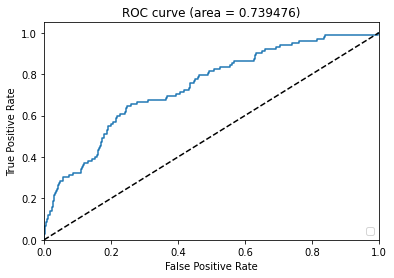

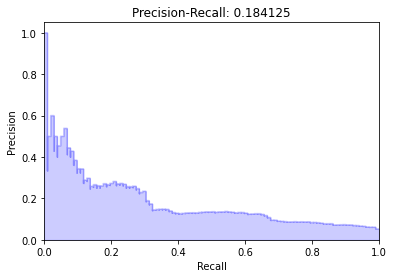

<IPython.core.display.Javascript object>

In [238]:
y_pred_prob = optimised_mlp.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

/mnt/nfs/home/subasriv/.conda/envs/vector_delirium/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


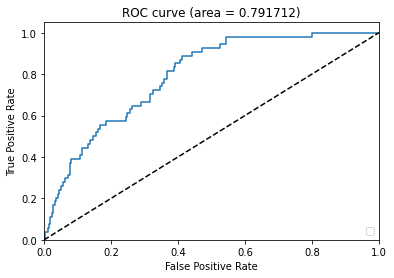

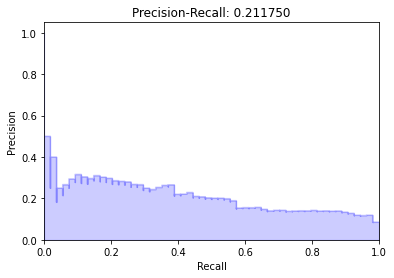

<IPython.core.display.Javascript object>

In [239]:
y_pred_prob = optimised_mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_pr = average_precision_score(y_test, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

### Random Forest ###

In [240]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_auc_score


def fit_rf(X, Y, Xv, Yv):
    best_n = None
    best_score = 0
    best_model = None
    for n in [5, 10, 50, 100, 500]:
        m = RF(n_estimators=n, n_jobs=-1)
        print("Fitting model with n:", n)
        m.fit(X, Y)
        Pv = m.predict_proba(Xv)[:, 1]
        score = roc_auc_score(Yv, Pv)
        if score > best_score:
            best_score = score
            best_model = m
            best_n = n

    print("Best n:", best_n)
    return best_model


optimised_rf = fit_rf(X_train, y_train, X_val, y_val)

Fitting model with n: 5
Fitting model with n: 10
Fitting model with n: 50
Fitting model with n: 100
Fitting model with n: 500
Best n: 500


<IPython.core.display.Javascript object>

In [241]:
y_pred = optimised_rf.predict(X_test)
print_metrics(y_test, y_pred)

Sensitivity: 0.018518518518518517
Specificity: 1.0
Positive Predictive Value: 1.0
False Positive Rate: 0.0
False Negative Rate: 0.9814814814814815
Accuracy: 0.9314359637774903


<IPython.core.display.Javascript object>

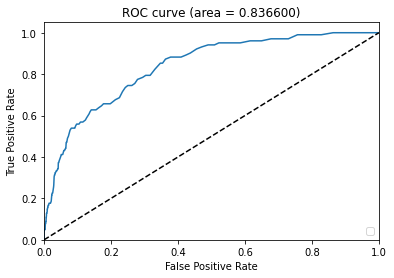

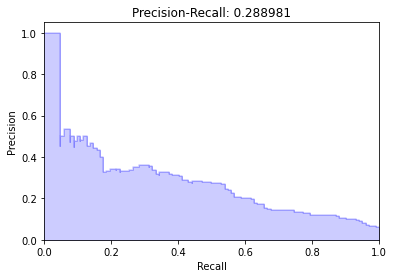

<IPython.core.display.Javascript object>

In [242]:
y_pred_prob = optimised_rf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

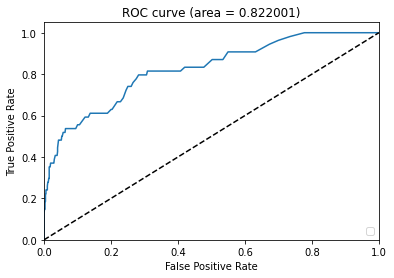

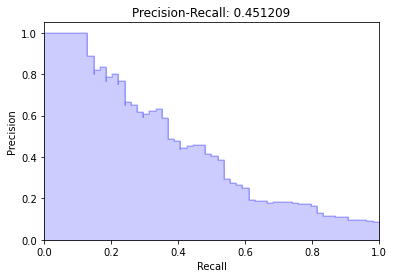

<IPython.core.display.Javascript object>

In [243]:
y_pred_prob = optimised_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_pr = average_precision_score(y_test, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

### Gradient Boosted Tree ###

In [266]:
X = pd.concat([x, x_ind], axis=1)
feat_remov = feat[feat > 9000].index
X = X.drop(feat_remov, axis=1)

X_train = X.loc[X.index.isin(ids_precovid)]
# label_column specifies the index of the column containing the true label
y_train = X_train["mortality_in_hospital"]
X_train = X_train.drop(columns=["mortality_in_hospital", "length_of_stay_in_er"])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.67)
X_test = X.loc[X.index.isin(ids_covid)]
y_test = X_test["mortality_in_hospital"]
X_test = X_test.drop(columns=["mortality_in_hospital", "length_of_stay_in_er"])

<IPython.core.display.Javascript object>

In [267]:
from xgboost import XGBClassifier


def fit_xgb(X, Y, Xv, Yv):
    best_n = None
    best_g = None
    best_score = 0
    best_model = None
    for n in [3, 5, 7, 9, 11]:
        for g in [0.5, 1, 1.5, 2, 5]:
            m = XGBClassifier(
                max_depth=n,
                gamma=g,
                objective="binary:logistic",
                learning_rate=0.1,
                eval_metric="logloss",
                min_child_weight=1,
                seed=42,
                use_label_encoder=False,
            )
            # print("Fitting model with n: {} and g: {}".format(n, g))
            m.fit(X, Y)
            Pv = m.predict_proba(Xv)[:, 1]
            score = roc_auc_score(Yv, Pv)
            if score > best_score:
                best_score = score
                best_model = m
                best_n = n
                best_g = g
    print("Best g:", best_g)
    print("Best n:", best_n)
    return best_model


optimised_xgb = fit_xgb(X_train, y_train, X_val, y_val)

Best g: 2
Best n: 5


<IPython.core.display.Javascript object>

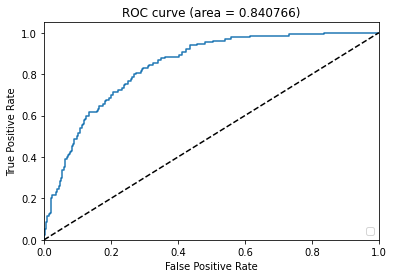

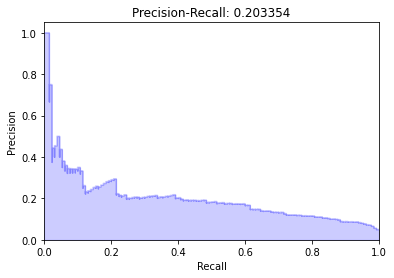

<IPython.core.display.Javascript object>

In [268]:
y_pred_prob = optimised_xgb.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

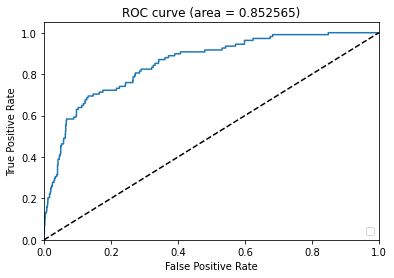

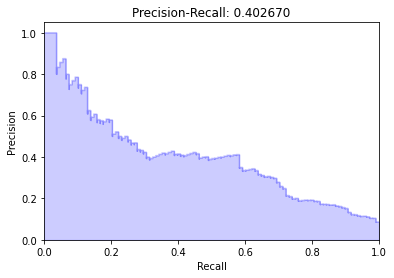

<IPython.core.display.Javascript object>

In [269]:
y_pred_prob = optimised_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_pr = average_precision_score(y_test, y_pred_prob)
plot_roc(fpr, tpr, roc_auc)
plot_pr(recall, precision, avg_pr)

## Drift Test ## 

In [14]:
path = "/path/"
dataset = "gemini"
samples = [10, 20, 50, 100, 200, 500, 1000, 2000]
# Number of random runs to average results over.
random_runs = 5
# Significance level.
sign_level = 0.05
# Whether to calculate accuracy for malignancy quantification.
calc_acc = True
na_cutoff = 5000
dr_techniques = ["NoRed", "SRP", "kPCA", "Isomap"]  # "PCA", "BBSDs_FFNN"]
# Statistical Tests
md_tests = ["MMD", "LSDD"]

<IPython.core.display.Javascript object>

In [15]:
times = ["pre-covid", "covid"]
mean_dr_md = np.ones((len(times), len(dr_techniques), len(md_tests), len(samples))) * (
    -1
)
std_dr_md = np.ones((len(times), len(dr_techniques), len(md_tests), len(samples))) * (
    -1
)

for ti, time in enumerate(times):
    for di, dr_technique in enumerate(dr_techniques):
        for mi, md_test in enumerate(md_tests):
            mean_p_vals, std_p_vals = run_shift_experiment(
                time,
                path,
                dr_technique,
                md_test,
                samples,
                dataset,
                sign_level,
                na_cutoff,
                features,
                random_runs,
                calc_acc=True,
            )
            mean_dr_md[ti, di, mi, :] = mean_p_vals
            std_dr_md[ti, di, mi, :] = std_p_vals

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:15:02,568 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:15:02,571 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:15:02,574 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift pre-covid


2022-03-17 12:15:08,159 INFO cyclops.utils.profile - Finished executing function process in 5.590303 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:15:18,876 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:15:18,878 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:15:18,881 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.2199999988079071


2022-03-17 12:15:24,562 INFO cyclops.utils.profile - Finished executing function process in 5.687597 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.30000001192092896
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5099999904632568
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:15:34,876 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:15:34,880 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:15:34,883 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.27000001072883606


2022-03-17 12:15:40,708 INFO cyclops.utils.profile - Finished executing function process in 5.832186 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:15:51,375 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:15:51,379 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:15:51,382 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.3499999940395355


2022-03-17 12:15:56,948 INFO cyclops.utils.profile - Finished executing function process in 5.573188 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3400000035762787
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:16:07,767 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:16:07,771 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:16:07,774 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.14000000059604645


2022-03-17 12:16:13,419 INFO cyclops.utils.profile - Finished executing function process in 5.651558 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:16:22,048 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:16:22,052 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:16:22,055 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.7200000286102295
Shift pre-covid


2022-03-17 12:16:28,154 INFO cyclops.utils.profile - Finished executing function process in 6.106497 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.20999999344348907
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8899999856948853
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:16:29,064 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:16:29,067 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:16:29,070 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.8199999928474426


2022-03-17 12:16:34,553 INFO cyclops.utils.profile - Finished executing function process in 5.488147 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:16:35,441 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:16:35,444 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:16:35,447 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.949999988079071


2022-03-17 12:16:41,020 INFO cyclops.utils.profile - Finished executing function process in 5.579063 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:16:41,893 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:16:41,895 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:16:41,899 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.2800000011920929


2022-03-17 12:16:47,459 INFO cyclops.utils.profile - Finished executing function process in 5.566623 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:16:48,342 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:16:48,344 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:16:48,347 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.8600000143051147


2022-03-17 12:16:54,022 INFO cyclops.utils.profile - Finished executing function process in 5.680637 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:16:54,900 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:16:54,904 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:16:54,908 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.8799999952316284
Shift pre-covid


2022-03-17 12:17:00,446 INFO cyclops.utils.profile - Finished executing function process in 5.546026 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:17:10,913 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:17:10,915 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:17:10,920 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.36000001430511475


2022-03-17 12:17:16,538 INFO cyclops.utils.profile - Finished executing function process in 5.624691 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3400000035762787
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:17:25,136 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:17:25,138 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:17:25,143 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.36000001430511475


2022-03-17 12:17:30,894 INFO cyclops.utils.profile - Finished executing function process in 5.757750 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.27000001072883606
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.28999999165534973
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.5699999928474426
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:17:41,214 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:17:41,220 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:17:41,223 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.6700000166893005


2022-03-17 12:17:46,967 INFO cyclops.utils.profile - Finished executing function process in 5.752870 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5099999904632568
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:17:57,723 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:17:57,729 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:17:57,732 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.1899999976158142


2022-03-17 12:18:03,511 INFO cyclops.utils.profile - Finished executing function process in 5.788460 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.27000001072883606
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9700000286102295
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:18:14,076 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:18:14,078 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:18:14,083 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.3199999928474426
Shift pre-covid


2022-03-17 12:18:19,678 INFO cyclops.utils.profile - Finished executing function process in 5.602117 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:18:20,508 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:18:20,510 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:18:20,513 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.7300000190734863


2022-03-17 12:18:26,171 INFO cyclops.utils.profile - Finished executing function process in 5.663165 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.949999988079071
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:18:27,095 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:18:27,097 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:18:27,100 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.28999999165534973


2022-03-17 12:18:32,783 INFO cyclops.utils.profile - Finished executing function process in 5.688721 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3100000023841858
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.949999988079071
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:18:33,632 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:18:33,635 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:18:33,638 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.44999998807907104


2022-03-17 12:18:39,417 INFO cyclops.utils.profile - Finished executing function process in 5.784654 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.5699999928474426
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:18:40,316 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:18:40,319 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:18:40,322 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.6100000143051147


2022-03-17 12:18:46,132 INFO cyclops.utils.profile - Finished executing function process in 5.814805 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  1.0
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9700000286102295
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:18:47,013 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:18:47,015 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:18:47,019 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.1599999964237213
Shift pre-covid


2022-03-17 12:18:52,637 INFO cyclops.utils.profile - Finished executing function process in 5.624316 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:19:07,641 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:19:07,643 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:19:07,647 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.30000001192092896


2022-03-17 12:19:13,247 INFO cyclops.utils.profile - Finished executing function process in 5.606060 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.699999988079071
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8899999856948853
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:19:28,136 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:19:28,140 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:19:28,143 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.5299999713897705


2022-03-17 12:19:33,675 INFO cyclops.utils.profile - Finished executing function process in 5.538535 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5099999904632568
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  1.0
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:19:48,610 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:19:48,616 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:19:48,619 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.8700000047683716


2022-03-17 12:19:54,317 INFO cyclops.utils.profile - Finished executing function process in 5.706559 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8899999856948853
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.699999988079071
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:20:09,734 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:20:09,736 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:20:09,740 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.3799999952316284


2022-03-17 12:20:15,289 INFO cyclops.utils.profile - Finished executing function process in 5.554549 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3100000023841858
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:20:30,077 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:20:30,079 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:20:30,082 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.2800000011920929
Shift pre-covid


2022-03-17 12:20:35,631 INFO cyclops.utils.profile - Finished executing function process in 5.554270 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:20:41,063 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:20:41,066 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:20:41,068 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.44999998807907104


2022-03-17 12:20:46,637 INFO cyclops.utils.profile - Finished executing function process in 5.573681 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.9700000286102295
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:20:51,805 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:20:51,807 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:20:51,810 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.7900000214576721


2022-03-17 12:20:57,394 INFO cyclops.utils.profile - Finished executing function process in 5.587520 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.949999988079071
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.30000001192092896
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:21:02,606 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:21:02,608 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:21:02,611 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.8199999928474426


2022-03-17 12:21:08,137 INFO cyclops.utils.profile - Finished executing function process in 5.531562 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5099999904632568
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:21:13,195 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:21:13,197 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:21:13,200 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.4399999976158142


2022-03-17 12:21:18,715 INFO cyclops.utils.profile - Finished executing function process in 5.520263 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3100000023841858
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:21:23,966 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:21:23,968 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:21:23,971 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.3700000047683716
Shift pre-covid


2022-03-17 12:21:29,510 INFO cyclops.utils.profile - Finished executing function process in 5.544109 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:22:28,420 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:22:28,423 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:22:28,425 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.15000000596046448


2022-03-17 12:22:34,217 INFO cyclops.utils.profile - Finished executing function process in 5.796586 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9599999785423279
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.699999988079071
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:23:32,863 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:23:32,866 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:23:32,868 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.4300000071525574


2022-03-17 12:23:38,475 INFO cyclops.utils.profile - Finished executing function process in 5.612313 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:24:53,342 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:24:53,345 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:24:53,348 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.30000001192092896


2022-03-17 12:24:58,971 INFO cyclops.utils.profile - Finished executing function process in 5.627128 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:26:20,768 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:26:20,772 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:26:20,775 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.20999999344348907


2022-03-17 12:26:26,475 INFO cyclops.utils.profile - Finished executing function process in 5.706905 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:27:43,998 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:27:44,002 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:27:44,006 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.8299999833106995
Shift pre-covid


2022-03-17 12:27:49,818 INFO cyclops.utils.profile - Finished executing function process in 5.820501 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:28:45,836 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:28:45,840 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:28:45,843 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.25999999046325684


2022-03-17 12:28:51,548 INFO cyclops.utils.profile - Finished executing function process in 5.712166 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8399999737739563
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197


2022-03-17 12:29:48,888 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:29:48,891 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:29:48,894 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-17 12:29:54,534 INFO cyclops.utils.profile - Finished executing function process in 5.646127 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:30:49,941 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:30:49,943 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:30:49,947 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.3400000035762787


2022-03-17 12:30:55,618 INFO cyclops.utils.profile - Finished executing function process in 5.678009 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.46000000834465027
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6600000262260437
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:31:52,147 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:31:52,150 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:31:52,154 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.23999999463558197


2022-03-17 12:31:57,713 INFO cyclops.utils.profile - Finished executing function process in 5.565408 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.27000001072883606
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:32:53,861 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:32:53,868 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:32:53,871 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.8299999833106995
Shift covid


2022-03-17 12:32:59,566 INFO cyclops.utils.profile - Finished executing function process in 5.705003 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5099999904632568
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.4699999988079071
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:33:27,837 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:33:27,840 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:33:27,845 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.18000000715255737


2022-03-17 12:33:33,651 INFO cyclops.utils.profile - Finished executing function process in 5.813882 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4699999988079071
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:34:02,742 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:34:02,747 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:34:02,755 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.019999999552965164


2022-03-17 12:34:08,384 INFO cyclops.utils.profile - Finished executing function process in 5.640421 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5699999928474426
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3400000035762787
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612


2022-03-17 12:34:34,757 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:34:34,767 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:34:34,769 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-17 12:34:40,415 INFO cyclops.utils.profile - Finished executing function process in 5.657734 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:35:09,541 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:35:09,543 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:35:09,545 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.07999999821186066


2022-03-17 12:35:15,347 INFO cyclops.utils.profile - Finished executing function process in 5.806554 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5099999904632568
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.46000000834465027
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.4699999988079071
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Shift covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:35:44,576 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:35:44,586 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:35:44,588 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-17 12:35:50,444 INFO cyclops.utils.profile - Finished executing function process in 5.867347 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:35:52,260 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:35:52,264 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:35:52,267 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0


2022-03-17 12:35:58,327 INFO cyclops.utils.profile - Finished executing function process in 6.067056 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:36:04,896 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:36:04,900 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:36:04,904 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0


2022-03-17 12:36:10,646 INFO cyclops.utils.profile - Finished executing function process in 5.749593 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:36:14,211 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:36:14,213 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:36:14,216 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0


2022-03-17 12:36:19,975 INFO cyclops.utils.profile - Finished executing function process in 5.763166 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:36:26,246 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:36:26,252 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:36:26,256 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0


2022-03-17 12:36:32,028 INFO cyclops.utils.profile - Finished executing function process in 5.782491 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:36:38,316 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:36:38,320 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:36:38,323 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0
Shift covid


2022-03-17 12:36:44,194 INFO cyclops.utils.profile - Finished executing function process in 5.878393 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.36000001430511475
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:37:12,998 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:37:13,003 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:37:13,006 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.36000001430511475


2022-03-17 12:37:18,862 INFO cyclops.utils.profile - Finished executing function process in 5.862410 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033


2022-03-17 12:37:47,903 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:37:47,906 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:37:47,909 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-17 12:37:53,758 INFO cyclops.utils.profile - Finished executing function process in 5.854079 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9900000095367432
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.38999998569488525
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0


2022-03-17 12:38:19,683 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:38:19,687 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:38:19,689 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-17 12:38:25,242 INFO cyclops.utils.profile - Finished executing function process in 5.559166 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:38:54,144 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:38:54,147 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:38:54,151 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.03999999910593033


2022-03-17 12:38:59,713 INFO cyclops.utils.profile - Finished executing function process in 5.569561 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5099999904632568
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:39:28,312 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:39:28,314 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:39:28,318 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0
Shift covid


2022-03-17 12:39:34,210 INFO cyclops.utils.profile - Finished executing function process in 5.898967 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:39:37,662 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:39:37,667 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:39:37,670 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.800000011920929


2022-03-17 12:39:43,400 INFO cyclops.utils.profile - Finished executing function process in 5.737421 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.27000001072883606
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:39:47,102 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:39:47,107 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:39:47,110 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0


2022-03-17 12:39:52,820 INFO cyclops.utils.profile - Finished executing function process in 5.717738 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:39:58,909 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:39:58,914 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:39:58,918 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0


2022-03-17 12:40:04,971 INFO cyclops.utils.profile - Finished executing function process in 6.061826 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:40:11,334 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:40:11,339 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:40:11,342 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.10999999940395355


2022-03-17 12:40:17,083 INFO cyclops.utils.profile - Finished executing function process in 5.748720 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9599999785423279
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.28999999165534973
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.46000000834465027
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:40:23,379 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:40:23,381 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:40:23,388 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.0
Shift covid


2022-03-17 12:40:29,694 INFO cyclops.utils.profile - Finished executing function process in 6.315602 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9900000095367432
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8399999737739563
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.25


2022-03-17 12:41:18,271 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:41:18,273 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:41:18,276 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-17 12:41:24,235 INFO cyclops.utils.profile - Finished executing function process in 5.964131 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.20999999344348907
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:42:19,550 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:42:19,554 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:42:19,558 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.019999999552965164


2022-03-17 12:42:25,110 INFO cyclops.utils.profile - Finished executing function process in 5.559622 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:43:15,958 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:43:15,960 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:43:15,962 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.07999999821186066


2022-03-17 12:43:21,718 INFO cyclops.utils.profile - Finished executing function process in 5.760183 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.27000001072883606
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:44:15,348 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:44:15,352 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:44:15,355 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.11999999731779099


2022-03-17 12:44:21,270 INFO cyclops.utils.profile - Finished executing function process in 5.922040 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Shift covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:45:14,374 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:45:14,378 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:45:14,381 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-17 12:45:20,208 INFO cyclops.utils.profile - Finished executing function process in 5.833657 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6600000262260437
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.27000001072883606
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.36000001430511475
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:45:48,371 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:45:48,374 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:45:48,377 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.49000000953674316


2022-03-17 12:45:54,147 INFO cyclops.utils.profile - Finished executing function process in 5.774356 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.46000000834465027
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:46:24,114 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:46:24,127 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:46:24,132 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.09000000357627869


2022-03-17 12:46:30,096 INFO cyclops.utils.profile - Finished executing function process in 5.982707 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.4699999988079071
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:46:55,389 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:46:55,393 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:46:55,396 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.10999999940395355


2022-03-17 12:47:01,046 INFO cyclops.utils.profile - Finished executing function process in 5.657348 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.30000001192092896
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3100000023841858
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:47:31,982 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:47:31,985 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:47:31,991 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.12999999523162842


2022-03-17 12:47:37,550 INFO cyclops.utils.profile - Finished executing function process in 5.567865 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 12:48:06,180 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:48:06,186 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:48:06,190 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.05000000074505806
Shift covid


2022-03-17 12:48:12,145 INFO cyclops.utils.profile - Finished executing function process in 5.964088 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3100000023841858
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.


2022-03-17 12:51:53,918 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:51:53,921 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:51:53,925 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.30000001192092896


2022-03-17 12:51:59,524 INFO cyclops.utils.profile - Finished executing function process in 5.607366 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5699999928474426
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8399999737739563
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:55:40,106 INFO cyclops.processors.base - Processing raw admin data...


Shift p-vals:  0.0


2022-03-17 12:55:40,112 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:55:40,117 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-17 12:55:45,838 INFO cyclops.utils.profile - Finished executing function process in 5.732760 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 12:59:28,753 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 12:59:28,757 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 12:59:28,760 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.1899999976158142


2022-03-17 12:59:34,491 INFO cyclops.utils.profile - Finished executing function process in 5.738254 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 4 : Sample 500
No GPU detected, fall back 

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
2022-03-17 13:07:04,957 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 13:07:04,964 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 13:07:04,968 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.1899999976158142
Shift covid


2022-03-17 13:07:11,035 INFO cyclops.utils.profile - Finished executing function process in 6.078169 s


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 13:10:48,229 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 13:10:48,234 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 13:10:48,237 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.47999998927116394


2022-03-17 13:10:53,756 INFO cyclops.utils.profile - Finished executing function process in 5.526709 s


Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 1 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 1 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 1 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582


2022-03-17 13:14:24,686 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 13:14:24,691 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 13:14:24,695 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756
2022-03-17 13:14:30,493 INFO cyclops.utils.profile - Finished executing function process in 5.807552 s


Random Run 2 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 2 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 2 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 2 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 2 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 2 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3100000023841858
Random Run 2 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 2 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 13:18:04,968 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 13:18:04,973 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 13:18:04,975 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.3100000023841858


2022-03-17 13:18:10,616 INFO cyclops.utils.profile - Finished executing function process in 5.647971 s


Random Run 3 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9700000286102295
Random Run 3 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 3 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 3 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 3 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 3 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 3 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 3 : Sample 2000
No GPU detected, fall back on CPU.


2022-03-17 13:21:43,012 INFO cyclops.processors.base - Processing raw admin data...
2022-03-17 13:21:43,016 INFO cyclops.processors.base - # samples: 10756, # encounters: 10756
2022-03-17 13:21:43,019 INFO cyclops.processors.admin - # admin features: 2, # encounters: 10756


Shift p-vals:  0.019999999552965164


2022-03-17 13:21:48,904 INFO cyclops.utils.profile - Finished executing function process in 5.892325 s


Random Run 4 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 4 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 4 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 4 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5099999904632568
Random Run 4 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 4 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 4 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 4 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322


<IPython.core.display.Javascript object>

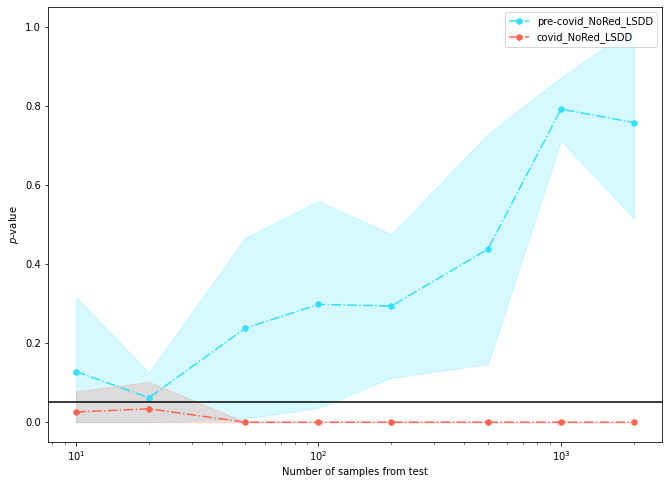

<IPython.core.display.Javascript object>

In [16]:
fig = plt.figure(figsize=(11, 8))
for ti, time in enumerate(times):
    for di, dr_technique in enumerate(dr_techniques):
        for mi, md_test in enumerate(md_tests):
            if di == 0 and mi == 1:
                errorfill(
                    np.array(samples),
                    mean_dr_md[ti, di, mi, :],
                    std_dr_md[ti, di, mi, :],
                    fmt=linestyles[mi] + markers[mi],
                    color=colorscale(colors[ti], brightness[di]),
                    label="%s" % "_".join([time, dr_technique, md_test]),
                )
plt.xlabel("Number of samples from test")
plt.ylabel("$p$-value")
plt.axhline(y=sign_level, color="k")
plt.legend()
plt.show()